# Trabalho 3 - Redes Neurais
Fazer um script em jupyter notebook para classificação de imagens.

Você deve plotar as curvas de erro de treino e validação.

Use a metodologia de validação Holdout.

Ao final, você deve gerar métricas para o conjunto de teste.

 Métricas de classificação: acurácia e f1 por classe. (consulte o scikit-learn)

## Imports
Primeiro é preciso importar as bibliotecas e funções a serem utilizadas.

In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.utils.data as data_utils
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, matthews_corrcoef

## Pegando os datasets
Utilizando o dataset CIFAR10 que possui link direto com o torchvision. É um dataset constituidos por imagens coloridas de veículos e animais onde existem 10 classes diferentes. O objetivo é criar um classificador a partir de uma CNN.

[Link para o dataset](https://www.cs.toronto.edu/~kriz/cifar.html)

In [2]:
train_dataset_base = datasets.CIFAR10(
    root = "data",
    train = True,
    transform = ToTensor(),
)

test_dataset = datasets.CIFAR10(
    root = "data",
    train = False,
    transform = ToTensor()
)

print("Shape of the train_dataset: ", train_dataset_base.data.shape)
print("Shape of the test_dataset: ", test_dataset.data.shape)
print("Classes: ", train_dataset_base.classes)

Shape of the train_dataset:  (50000, 32, 32, 3)
Shape of the test_dataset:  (10000, 32, 32, 3)
Classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Dividindo e Transformando o Dataset

In [3]:
# Criando um dataset de validação a partir do treino
train_dataset, valid_dataset = data_utils.random_split(train_dataset_base, [40000, 10000])

# Criando os dataloaders com o batch_size de 64
train_loader = data_utils.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = data_utils.DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = data_utils.DataLoader(test_dataset, batch_size=64, shuffle=True)

## Definindo o device
Como minha placa de vídeo é AMD não possuo Cuda.

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


## Definindo a Rede Neural
Criei uma classe que herda nn.Module e defini as camadas da rede aqui. Usei um modelo base de CNN apenas para facilitar.

In [5]:
class NeuralNetwork(nn.Module):
    
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Jogando a Rede para a CPU

In [6]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Definindo a loss function e o otimizador
Learning rate inicial de 0.01 pois foi a com melhor desempenho.

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## Treinando e Validando a Rede
### Funções para implementar o treino e a validação
Realizam os ajustes de pesos das redes e calculam a perda e acurácia do algoritmo

In [8]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    loss_sum = 0
    i = 0
    for X, y in dataloader:
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_sum += loss.item() * len(X)
        
    avg_loss = loss_sum / size 
    print(f"Train Error: Avg loss = {avg_loss:>8f}")
    return avg_loss

In [9]:
def valid_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    loss, correct = 0, 0

    with torch.no_grad():
      for X, y in dataloader:
          pred = model(X)
          loss += loss_fn(pred, y).item() * len(X)
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_loss = loss / size
    acc      = correct / size  
    print(f"Test Error: Accuracy = {100*acc:>0.1f}%, Avg loss = {avg_loss:>8f}")
    
    return avg_loss, acc

### Loop do Treino
Utilizei 50 epochs pois o desempenho não melhorava muito depois disso. Salvei o modelo com melhor desempenho de perda na validação.

In [10]:
n_epoch = 50
loss_valid_history = []
acc_history = []
loss_train_history = []
min_loss_valid = np.Inf


for epoch in range(n_epoch):
    print(f"Epoch {epoch+1}\n-----------------------------------")
    loss_train = train_loop(train_loader, model, loss_fn, optimizer)
    loss_valid, accuracy = valid_loop(valid_loader, model, loss_fn)
    if  loss_valid <= min_loss_valid:
        print(f"Validation loss decreased ({min_loss_valid:>0.6f} --> {loss_valid:>0.6f}).  Saving model ...")
        min_loss_valid = loss_valid
        torch.save(model.state_dict(), 'models/best_model_trab3.pt')
    print("-----------------------------------\n")


    loss_train_history.append(loss_train)
    loss_valid_history.append(loss_valid)
    acc_history.append(accuracy)

Epoch 1
-----------------------------------
Train Error: Avg loss = 2.301983
Test Error: Accuracy = 12.0%, Avg loss = 2.299056
Validation loss decreased (inf --> 2.299056).  Saving model ...
-----------------------------------

Epoch 2
-----------------------------------
Train Error: Avg loss = 2.292651
Test Error: Accuracy = 16.4%, Avg loss = 2.277575
Validation loss decreased (2.299056 --> 2.277575).  Saving model ...
-----------------------------------

Epoch 3
-----------------------------------
Train Error: Avg loss = 2.209371
Test Error: Accuracy = 23.3%, Avg loss = 2.132837
Validation loss decreased (2.277575 --> 2.132837).  Saving model ...
-----------------------------------

Epoch 4
-----------------------------------
Train Error: Avg loss = 2.039506
Test Error: Accuracy = 28.0%, Avg loss = 1.994714
Validation loss decreased (2.132837 --> 1.994714).  Saving model ...
-----------------------------------

Epoch 5
-----------------------------------
Train Error: Avg loss = 1.946

### Desempenho no treino e na validação
Gráficos que mostram como foi a redução da loss function de acordo com as epócas de treino, tanto na validação quanto do próprio treino.

C:\Users\sergi\AppData\Local\Temp\ipykernel_15276\2620626654.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


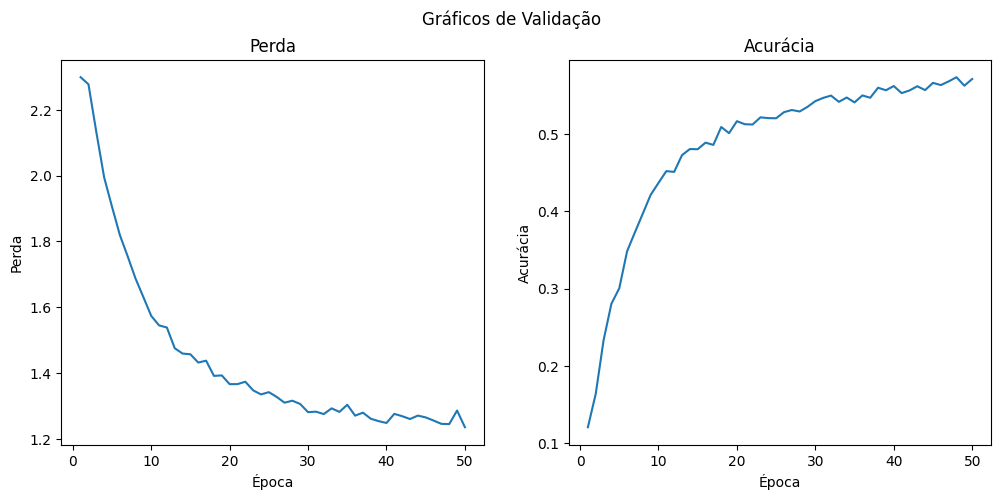

In [11]:
epoch_vec = list(range(1, n_epoch+1))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Gráficos de Validação')
fig.set_size_inches(12, 5)

ax1.set_title('Perda')
ax1.set_xlabel('Época')
ax1.set_ylabel('Perda')
ax1.plot(epoch_vec, loss_valid_history, label='loss')

ax2.set_title('Acurácia')
ax2.set_xlabel('Época')
ax2.set_ylabel('Acurácia')
ax2.plot(epoch_vec, acc_history, label='acuracy')

fig.show()

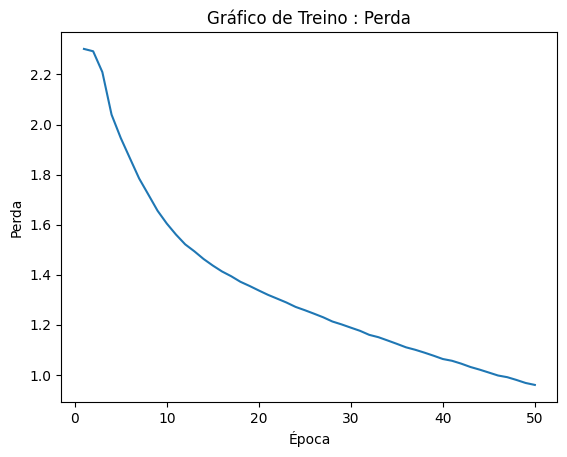

In [12]:
plt.title('Gráfico de Treino : Perda')
plt.plot(epoch_vec, loss_train_history, label='loss')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.show()

## Testando o Modelo

### Pegando o Melhor modelo

In [13]:
model.load_state_dict(torch.load('models/best_model_trab3.pt'))

<All keys matched successfully>

### Função que executa os testes

In [14]:
def test_loop(dataloader, model):
    y_pred = []
    y_true = []

    for X, y in dataloader:
        pred = model(X)
        pred = (torch.max(torch.exp(pred), 1)[1]).data.cpu().numpy()
        y_pred.extend(pred)

        y = y.data.cpu().numpy()
        y_true.extend(y)

    return y_true, y_pred

## Resultados

O resultados encontrados são mostrados a seguir, para um problema de classificação com 10 classes uma acurácia acima de 55% deve ser considerada. Além disso, é possível perceber que apenas ao aplicar o modelo da CNN o desempenho entre o trabalho 1 que eu utilizei o mesmo dataset melhorou bastante.

airplane:
	Precision: 63.40% 
	Recall: 64.10% 
	F1-Score: 63.75%
automobile:
	Precision: 67.85% 
	Recall: 70.50% 
	F1-Score: 69.15%
bird:
	Precision: 45.49% 
	Recall: 51.90% 
	F1-Score: 48.48%
cat:
	Precision: 41.33% 
	Recall: 39.80% 
	F1-Score: 40.55%
deer:
	Precision: 53.77% 
	Recall: 46.40% 
	F1-Score: 49.81%
dog:
	Precision: 52.73% 
	Recall: 37.70% 
	F1-Score: 43.97%
frog:
	Precision: 57.41% 
	Recall: 70.50% 
	F1-Score: 63.29%
horse:
	Precision: 67.23% 
	Recall: 63.40% 
	F1-Score: 65.26%
ship:
	Precision: 62.49% 
	Recall: 76.80% 
	F1-Score: 68.91%
truck:
	Precision: 64.86% 
	Recall: 56.30% 
	F1-Score: 60.28%

Acurácia: 57.74%

MCC: 0.53


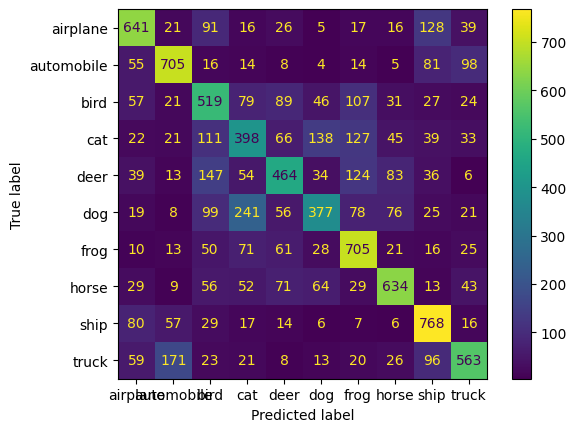

In [15]:
y_true, y_pred = test_loop(test_loader, model)

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels = test_dataset.classes).plot()
report = classification_report(y_true, y_pred, output_dict=True)

for i in range(len(test_dataset.classes)):
    print(f"{test_dataset.classes[i]}:\n\tPrecision: {report[str(i)]['precision']*100:>.02f}% \n\tRecall: {report[str(i)]['recall']*100:>.02f}% \n\tF1-Score: {report[str(i)]['f1-score']*100:>.02f}%")

print(f"\nAcurácia: {report['accuracy']*100:>.02f}%")
mcc = matthews_corrcoef(y_true, y_pred)
print(f"\nMCC: {mcc:>.02f}")